[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/router.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239412-lesson-5-router)

# Router

## Review

We built a graph that uses `messages` as state and a chat model with bound tools.

We saw that the graph can:

* Return a tool call
* Return a natural language response

## Goals

We can think of this as a router, where the chat model routes between a direct response or a tool call based upon the user input.

This is a simple example of an agent, where the LLM is directing the control flow either by calling a tool or just responding directly. 

![Screenshot 2024-08-21 at 9.24.09 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)

Let's extend our graph to work with either output! 

For this, we can use two ideas:

(1) Add a node that will call our tool.

(2) Add a conditional edge that will look at the chat model output, and route to our tool calling node or simply end if no tool call is performed. 



In [7]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt

In [8]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [9]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([multiply])

#### llm.bind_tools([multiply]) ####

# This binds the multiply function as a tool that the LLM is aware of.
# The LLM can now respond with a tool call when needed.
# It does not execute the tool, it just allows the LLM to produce a tool call in its output.

 We use the [built-in `ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode) and simply pass a list of our tools to initialize it.

**Tool Node** :-
- This is the node in the graph that actually executes the tool when a tool call is detected.
- When the LLM returns a tool call, LangGraph routes the state to this node.
- The ToolNode will:
  - Match the tool call’s name with the function (multiply here).
  - Execute multiply(a, b) with the arguments.
  - Append the result as a message to the state.
  - So ToolNode = executor, not just awareness.


- A node that runs the tools called in the last AIMessage.
- It can be used either in StateGraph with a "messages" state key (or a custom key passed via ToolNode's 'messages_key'). If multiple tool calls are requested, they will be run in parallel
- The output will be a list of ToolMessages, one for each tool call.
- Tool calls can also be passed directly as a list of ToolCall dicts.
- The node will return a list of ToolMessages, one for each tool call.

**tools_condition** :-
- It’s used with "add_conditional_edges" to decide where the graph should go based on whether the LLM just requested a tool call.
- tools_condition checks the latest message and routes the flow accordingly.
- It looks at the last message in the state (state["messages"][-1]). If the LLM responded with a tool call, it returns "tools" (the name of your ToolNode). If not, it returns END (the special marker that ends the graph).
- A conditional edge that checks the last message in the state.
- If the last message is a ToolMessage, it will route to the "tools" node.
- If the last message is not a ToolMessage, it will route to END.
- It can be used in StateGraph with a "messages" state key (or a custom key passed via tools_condition's 'messages_key').
- It can also be used with a custom condition function that takes the state and returns True or False.

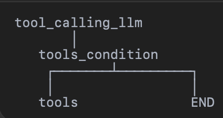

Summary:-
- tools_condition is a router: “Did the LLM just call a tool?”
- yes → route to the tools node (where ToolNode executes the tool).
- no → go to END (or another path).

 We use the [built-in `tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition) as our conditional edge.

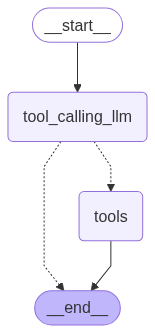

In [10]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
##
# If the latest message (result) from assistant is a tool call -> tools_condition routes to tools node
# If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
builder.add_conditional_edges("tool_calling_llm",tools_condition,)
##
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hello, what is 2 multiplied by 2?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, what is 2 multiplied by 2?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_VzGGLsy51UU4yuCrpABSLMtM)
 Call ID: call_VzGGLsy51UU4yuCrpABSLMtM
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: multiply

4


Now, we can see that the graph runs the tool!

It responds with a `ToolMessage`. 

## LangGraph Studio

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.
Load the `router` in Studio, which uses `module-1/studio/router.py` set in `module-1/studio/langgraph.json`.

In [7]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")